In [1]:
import pandas as pd
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt

In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

In [ ]:
img = np.load(
    "../../100_data/test_spec.npz",
    allow_pickle=True,
)
aug = np.load(
    "../201_processing/augmented_spec.npz",
    allow_pickle=True,
)
X_tr = aug['X_train']
y_tr = aug['y_train']

img_X = img['X']
img_y = img['y']
X_tr.shape, y_tr.shape

((4794, 128, 128, 3), (4794,))

In [4]:
from sklearn.model_selection import train_test_split

_, X_te, _, y_te = train_test_split(
    img_X, img_y, test_size=0.2, random_state=42)

In [5]:
genre_names = [
    "blues",
    "classical",
    "country",
    "disco",
    "hiphop",
    "jazz",
    "metal",
    "pop",
    "reggae",
    "rock",
]

# Get y train values from strings to ints
genre_to_index = {genre: idx for idx, genre in enumerate(genre_names)}

# Convert genre names to their numeric index
y_tr = np.array([genre_to_index[genre] for genre in y_tr])
y_tr.shape

(4794,)

In [6]:
X_train = torch.from_numpy(X_tr)
# y_ohe_tr = torch.from_numpy(y_tr)
y_train = torch.from_numpy(y_tr)

X_test = torch.from_numpy(X_te)
y_ohe_te = torch.from_numpy(y_te)
y_test = torch.argmax(y_ohe_te, dim=1)

In [7]:
X_train_perm = X_train.permute(
    0, 3, 1, 2
)  # This changes the shape to [799, 3, 128, 128]

X_train_perm.shape, y_train.shape

(torch.Size([4794, 3, 128, 128]), torch.Size([4794]))

In [8]:
from torch.utils.data import TensorDataset

train_dataset_n = TensorDataset(X_train_perm, y_train)

X_test_perm = X_test.permute(0, 3, 1, 2)  # Reorder test data dimensions
test_dataset = TensorDataset(X_test_perm, y_test)


In [9]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset_n, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Mix (Some epochs, freeze all but last layer; other epochs, unfreeze everything)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

res1 = models.resnet18(pretrained=True)
res1.fc = torch.nn.Linear(res1.fc.in_features, 10) # 10 genres

for param in res1.parameters():
    param.requires_grad = False # Freeze all layers

for param in res1.fc.parameters():
  param.requires_grad = True # Unfreeze last layer


# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
res1 = res1.to(device)

# 1. Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(res1.fc.parameters(), lr=0.001)  # fine-tune only last layer

# 2. Training loop
num_frozen_epochs = 15

for epoch in range(num_frozen_epochs):
    res1.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device).type(torch.float32)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = res1(images)

        # Loss calculation
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f"Frozen Epoch [{epoch+1}/{num_frozen_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

for param in res1.parameters():
    param.requires_grad = True # Unfreeze all layers

num_unfrozen_epochs = 5
optimizer = optim.Adam(res1.parameters(), lr=0.00001) # fine-tune all

for param in res1.parameters():
    param.requires_grad = True

for epoch in range(num_unfrozen_epochs):
    res1.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device).type(torch.float32)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = res1(images)

        # Loss calculation
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f"Unfrozen Epoch [{epoch+1}/{num_unfrozen_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

print("Fine-tuning complete.")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 99.1MB/s]


Frozen Epoch [1/15], Loss: 1.8002, Accuracy: 37.88%
Frozen Epoch [2/15], Loss: 1.3615, Accuracy: 53.96%
Frozen Epoch [3/15], Loss: 1.2251, Accuracy: 58.34%
Frozen Epoch [4/15], Loss: 1.1559, Accuracy: 60.72%
Frozen Epoch [5/15], Loss: 1.1116, Accuracy: 61.95%
Frozen Epoch [6/15], Loss: 1.0445, Accuracy: 64.54%
Frozen Epoch [7/15], Loss: 1.0275, Accuracy: 64.98%
Frozen Epoch [8/15], Loss: 1.0048, Accuracy: 65.37%
Frozen Epoch [9/15], Loss: 1.0048, Accuracy: 65.58%
Frozen Epoch [10/15], Loss: 0.9820, Accuracy: 67.38%
Frozen Epoch [11/15], Loss: 0.9515, Accuracy: 67.40%
Frozen Epoch [12/15], Loss: 0.9385, Accuracy: 67.42%
Frozen Epoch [13/15], Loss: 0.9237, Accuracy: 68.09%
Frozen Epoch [14/15], Loss: 0.9200, Accuracy: 68.52%
Frozen Epoch [15/15], Loss: 0.9382, Accuracy: 67.98%
Unfrozen Epoch [1/5], Loss: 0.7869, Accuracy: 72.86%
Unfrozen Epoch [2/5], Loss: 0.4736, Accuracy: 85.79%
Unfrozen Epoch [3/5], Loss: 0.3187, Accuracy: 92.26%
Unfrozen Epoch [4/5], Loss: 0.2109, Accuracy: 96.25%
Un

In [11]:
# Testing
res1.eval()

with torch.no_grad():
    outputs = res1(X_test_perm.to(device).type(torch.float32))
    _, predicted = torch.max(outputs.data, 1)
    total = y_test.size(0)
    correct = (predicted == y_test.to(device)).sum()
    acc = 100 * correct / total
    print(f"Accuracy: {acc:.2f}%")

Accuracy: 67.00%


              precision    recall  f1-score   support

       blues       0.54      0.71      0.61        21
   classical       0.71      1.00      0.83        12
     country       0.60      0.50      0.55        24
       disco       0.59      0.45      0.51        22
      hiphop       0.75      0.80      0.77        15
        jazz       0.93      0.93      0.93        27
       metal       0.83      0.83      0.83        18
         pop       0.68      0.79      0.73        19
      reggae       0.57      0.55      0.56        22
        rock       0.43      0.30      0.35        20

    accuracy                           0.67       200
   macro avg       0.66      0.69      0.67       200
weighted avg       0.66      0.67      0.66       200



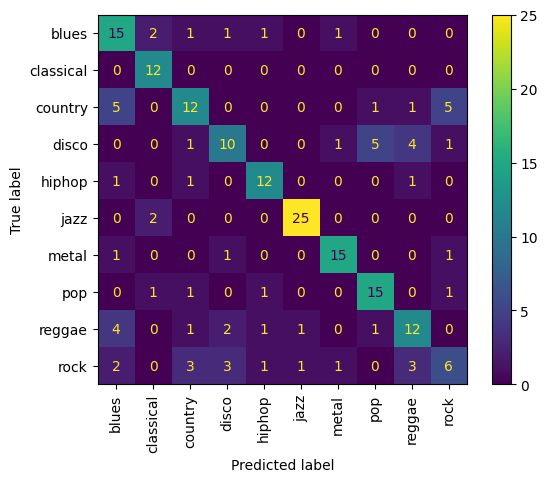

In [12]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

actual = y_test.cpu().numpy()
preds = predicted.cpu().numpy()

print(classification_report(actual, preds, target_names=genre_names))
cm  = confusion_matrix(actual, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genre_names)
disp.plot()
plt.xticks(rotation=90)
plt.show()

Old Stuff

In [ ]:
from torch.utils.data import TensorDataset, Subset, random_split

dataset = TensorDataset(X_tensor, y_tensor)

# Step 2: Shuffle the dataset indices
num_samples = len(dataset)
shuffled_indices = torch.randperm(num_samples)

# Step 3: Split the shuffled indices
train_size = int(0.8 * num_samples)
train_indices = shuffled_indices[:train_size]
test_indices = shuffled_indices[train_size:]

# Step 4: Create training and testing datasets directly
X_train = X_tensor[train_indices]
y_train = y_tensor[train_indices]
X_test = X_tensor[test_indices]
y_test = y_tensor[test_indices]

#train_dataset = TensorDataset(X_train, y_train)
#test_dataset = TensorDataset(X_test, y_test)

NameError: name 'X_tensor' is not defined